# RUN THIS CELL FIRST!
pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

from dotenv import load_dotenv, find_dotenv

# Load API key
load_dotenv(find_dotenv())


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

In [2]:
# Get API key
api_key = os.getenv("OPENAI_API_KEY")

# Initialize LLM
llm = OpenAI(model_name="text-davinci-003", model_kwargs={"api_key": api_key})

In [3]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("NIST.SP.800-160v1.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('NIST.SP.800-160v1.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('NIST.SP.800-160v1.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

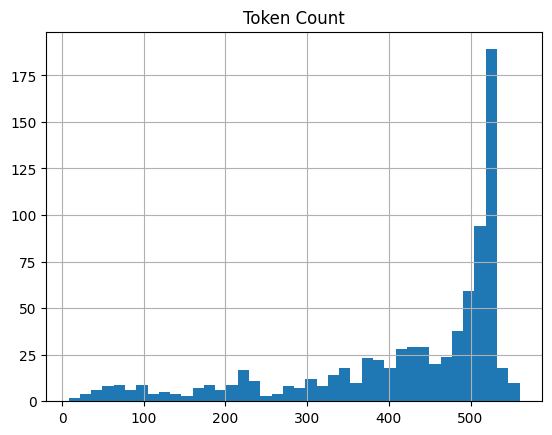

In [4]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [5]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

In [6]:
# Check similarity search is working
query = "How many NIST requirements are there?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='National Institute of Standards and Technology Special Publication \n(SP) 800-137, Information Security Continuous Monitoring for \nFederal Information Systems and Organizations, September 2011. \nhttps://doi.org/10.6028/NIST.SP.800-137 \nNational Institute of Standards and Technology Special Publication \n(SP) 800-181, National Initiative for Cybersecurity Education \n(NICE) Cybersecurity Workforce Framework, August 2017. \nhttps://doi.org/10.6028/NIST.SP.800-181', metadata={})

In [7]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "How are requirements listed in this document?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' Requirements are listed as informal statements or expressions of stakeholder security requirements focused on protecting information, systems, and services associated with mission/business functions throughout the system life cycle.'

In [8]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [9]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        print("Thank you for using the NIST chatbot!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue"NIST Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the NIST chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the NIST chatbot! Type 'exit' to stop.


/var/folders/8w/4mj_4m4d0rs1q22bl9g77hhw0000gn/T/ipykernel_48918/113576278.py:20: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='Please enter your question:')